<a href="https://colab.research.google.com/github/mnunezr1/CSCI-166-Project/blob/main/CSCI_166_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 17.3 MB/s eta 0:00:00


In [ ]:
!pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.2 MB/s eta 0:00:00


In [ ]:
!pip install "gymnasium[box2d]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376475 sha256=1d840454bc8f5486662d3bea3fcf6beb9117992b3a58b12c88b0cc42683a0d9c
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [ ]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import moviepy.editor as mpy
import os
import PIL.Image as Image
import numpy as np
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque


  if event.key is 'enter':



##HyperParameters

In [ ]:
# Hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.95  # Discount factor
epsilon = 1.0  # Exploration rate for Q_Learning and Deep Q-Learning
apx_epsilon = 0.1 #For Approx. Q_Learning
epsilon_min = 0.01 #For Q_Learning
epsilon_decay = 0.995 #For Q_Learning
num_training_episodes = 10000
num_evaluation_episodes = 1000
max_steps = 300 #For Approximate Q_learning and Q_Learning

##Q-Learning w/ Frozen Lake

In [ ]:
# Create Frozen Lake environment
env = gym.make("FrozenLake-v1", is_slippery=True, render_mode="rgb_array")  # Set is_slippery=True for stochastic environment

# Q-Learning algorithm function
# Q-Learning algorithm function
def q_learning(env, num_training_episodes, max_steps, alpha, gamma, epsilon, epsilon_min, epsilon_decay):
    # Initialize Q-table with zeros
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    episode_lengths = []
    episode_rewards = []

    # Function for Epsilon-Greedy policy
    def epsilon_greedy_action(state, Q, epsilon):
        if np.random.rand() < epsilon:
            return env.action_space.sample()  # Exploration
        else:
            return np.argmax(Q[state])  # Exploitation

    # Q-Learning loop
    for episode in tqdm(range(num_training_episodes)):
        state, _ = env.reset()
        state = int(state)
        done = False
        total_reward = 0
        steps = 0

        for step in range(max_steps):
            # Select action using epsilon-greedy policy
            action = epsilon_greedy_action(state, Q, epsilon)

            # Perform action and observe the next state and reward
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated  # Combine termination conditions

            # Update Q-value
            best_next_action = np.argmax(Q[next_state])
            Q[state, action] = Q[state, action] + alpha * (
                reward + gamma * Q[next_state, best_next_action] - Q[state, action]
            )

            # Update metrics
            total_reward += reward
            steps += 1

            # Move to the next state
            state = next_state

            if done:
                break

        # Record episode metrics
        episode_lengths.append(steps)
        episode_rewards.append(total_reward)

        # Decay epsilon to reduce exploration over time
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Extract the optimal policy from Q-table
    optimal_policy = np.argmax(Q, axis=1)
    return Q, optimal_policy, episode_lengths, episode_rewards

# Apply Q-learning
Q_table, optimal_policy_q_learning, episode_lengths, episode_rewards = q_learning(env, num_training_episodes, max_steps, alpha, gamma, epsilon, epsilon_min, epsilon_decay)

100%|██████████| 10000/10000 [00:17<00:00, 570.06it/s]


In [ ]:
def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

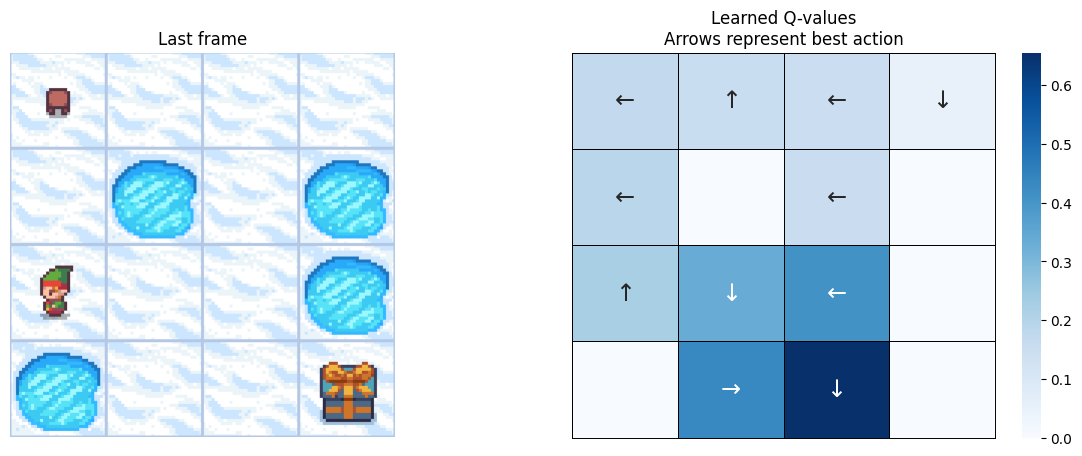

In [ ]:
# Plot the last frame
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].imshow(env.render())
ax[0].axis("off")
ax[0].set_title("Last frame")

# Plot the policy
qtable_val_max, qtable_directions = qtable_directions_map(Q_table, map_size=4)
sns.heatmap(
    qtable_val_max,
    annot=qtable_directions,
    fmt="",
    ax=ax[1],
    cmap=sns.color_palette("Blues", as_cmap=True),
    linewidths=0.7,
    linecolor="black",
    xticklabels=[],
    yticklabels=[],
    annot_kws={"fontsize": "xx-large"},
).set(title="Learned Q-values\nArrows represent best action")
for _, spine in ax[1].spines.items():
    spine.set_visible(True)
    spine.set_linewidth(0.7)
    spine.set_color("black")

img_title = f"frozenlake_q_values_{4}x{4}.png"
savefig_folder = "./Qmap_images"  # Replace with your desired folder path
# Create the folder if it doesn't exist
os.makedirs(savefig_folder, exist_ok=True)
fig.savefig(os.path.join(savefig_folder, img_title), bbox_inches="tight")
plt.show()

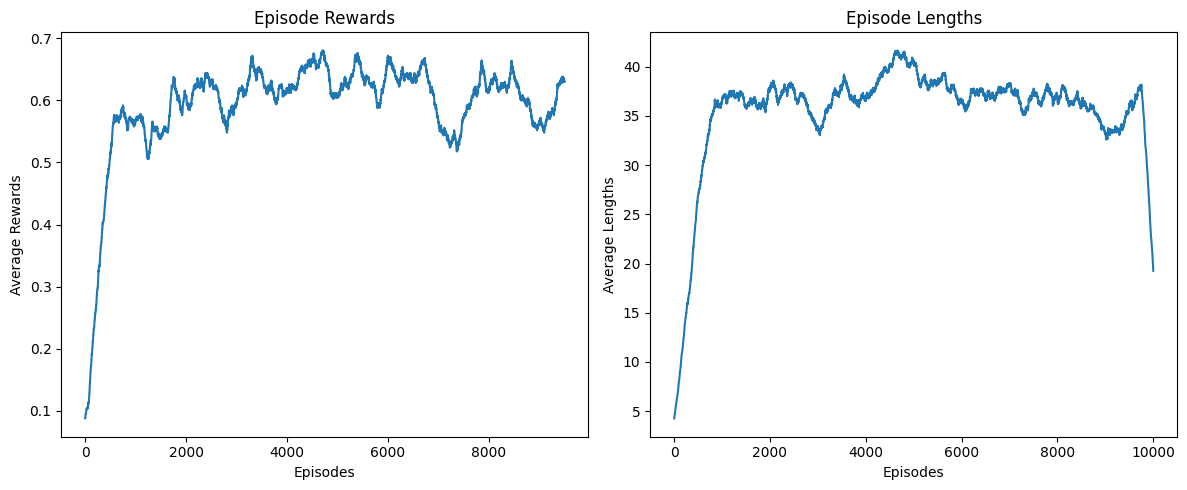

In [ ]:
# Create the plots for rewards and lengths
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
rolling_length = 500

# Episode rewards plot
axs[0].set_title("Episode Rewards")
reward_moving_average = (
    np.convolve(
        np.array(episode_rewards).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[0].set_xlabel("Episodes")
axs[0].set_ylabel("Average Rewards")

# Episode lengths plot
axs[1].set_title("Episode Lengths")
length_moving_average = (
    np.convolve(
        np.array(episode_lengths).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[1].set_xlabel("Episodes")
axs[1].set_ylabel("Average Lengths")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()
env.close()

## Aproximate Q-Learning w/ Mountain Car

In [ ]:
# Feature extraction function
def extract_features(state, action):
    """
    Generate features for a given state-action pair.
    Combines state and action as features (simple representation).
    """
    return np.append(state, action)

# Approximate Q-Learning agent
class ApproximateQLearningAgent:
    def __init__(self, state_dim, action_dim, alpha, gamma):
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.weights = np.zeros(state_dim + action_dim)  # Initialize weights

    def get_q_value(self, state, action):
        features = extract_features(state, action)
        return np.dot(self.weights, features)

    def update(self, state, action, reward, next_state, done):
        """
        Update the weights based on the transition.
        """
        features = extract_features(state, action)
        q_value = self.get_q_value(state, action)

        # Determine the maximum Q-value for the next state over all actions
        # Since it's a continuous action space, we'll sample some actions
        sampled_actions = np.linspace(-1, 1, 10)  # Sample 10 actions in the range [-1, 1]
        max_q_next = max(self.get_q_value(next_state, a) for a in sampled_actions)

        # Target value
        target = reward + (0 if done else self.gamma * max_q_next)

        # Temporal difference error
        td_error = target - q_value

        # Gradient descent update
        self.weights += self.alpha * td_error * features

    def select_action(self, state):
        """
        Select an action using a policy derived from the Q-values (e.g., greedy policy).
        """
        sampled_actions = np.linspace(-1, 1, 10)  # Sample actions in the range [-1, 1]
        q_values = [self.get_q_value(state, a) for a in sampled_actions]
        best_action = sampled_actions[np.argmax(q_values)]
        return best_action



env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
state_dim = env.observation_space.shape[0]
action_dim = 1  # The action space is continuous, but we treat it as a single scalar

# Initialize the agent
agent = ApproximateQLearningAgent(state_dim, action_dim, alpha, gamma)

In [ ]:
# Variables for tracking rewards and episode lengths
episode_rewards = []
episode_lengths = []

# Training loop
for episode in tqdm(range(num_training_episodes)):
    state, _ = env.reset()
    total_reward = 0
    step_count = 0

    for step in range(max_steps):
        # Select an action
        action = agent.select_action(state)

        # Take action in the environment
        next_state, reward, done, truncated, _ = env.step([action])
        total_reward += reward

        # Update the agent
        agent.update(state, action, reward, next_state, done)

        # Transition to the next state
        state = next_state
        step_count += 1

        if done or truncated:
            break

    # Record episode metrics
    episode_rewards.append(total_reward)
    episode_lengths.append(step_count)

100%|██████████| 10000/10000 [09:59<00:00, 16.69it/s]


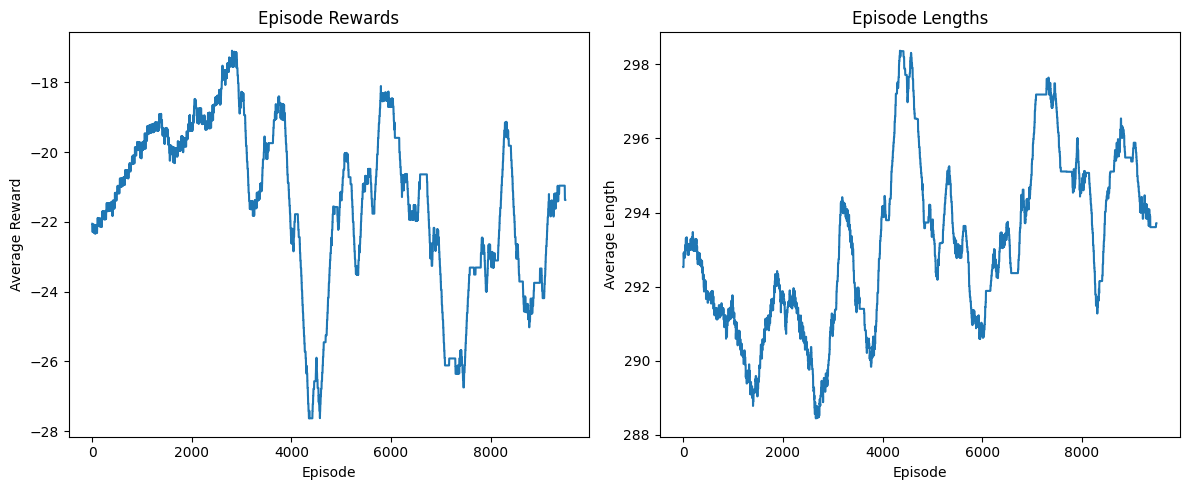

In [ ]:
# Plot rewards and lengths
rolling_length = 500  # Adjust the rolling average window for smoothing
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

# Episode rewards
axs[0].set_title("Episode Rewards")
reward_moving_average = (
    np.convolve(np.array(episode_rewards), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Average Reward")

# Episode lengths
axs[1].set_title("Episode Lengths")
length_moving_average = (
    np.convolve(np.array(episode_lengths), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Average Length")

plt.tight_layout()
plt.show()

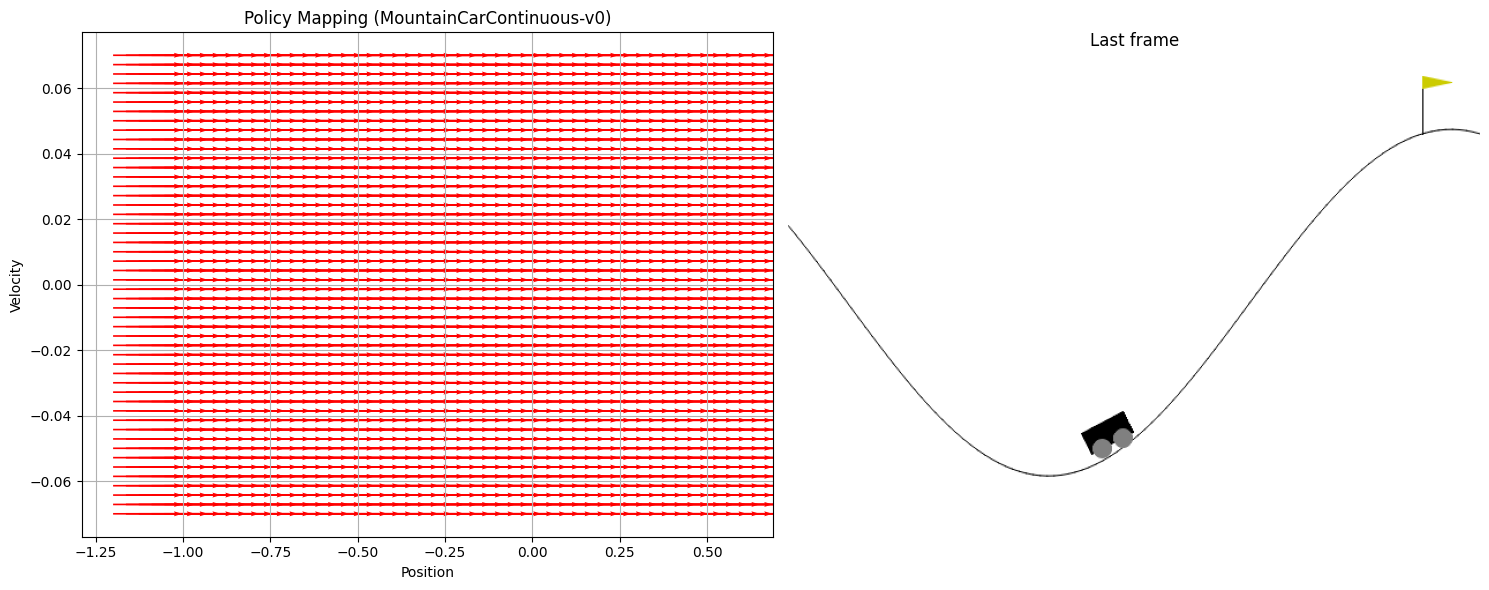

In [ ]:
# Map the policy
grid_points = 50  # Number of points to sample along each dimension
state_bounds = list(zip(env.observation_space.low, env.observation_space.high))
x = np.linspace(state_bounds[0][0], state_bounds[0][1], grid_points)
y = np.linspace(state_bounds[1][0], state_bounds[1][1], grid_points)

X, Y = np.meshgrid(x, y)
actions = np.zeros_like(X)

for i in range(grid_points):
    for j in range(grid_points):
        state = np.array([X[i, j], Y[i, j]])
        action = agent.select_action(state)
        actions[i, j] = action

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))  # Adjust figsize as needed

# Plot the policy on the first subplot (ax1)
ax1.quiver(X, Y, actions, np.zeros_like(actions), scale=10, color="r")
ax1.set_title("Policy Mapping (MountainCarContinuous-v0)")
ax1.set_xlabel("Position")
ax1.set_ylabel("Velocity")
ax1.grid(True)

# Plot the last frame on the second subplot (ax2)
ax2.imshow(env.render())
ax2.set_title("Last frame")
ax2.axis("off")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

env.close()

##Deep Q-Learning


Libraries and Initialize the Environment

In [ ]:
# Initialize the Lunar Lander environment
env = gym.make("LunarLander-v3", render_mode="rgb_array")

# Set the random seed for reproducibility
seed = 42
env.reset(seed=seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Set random seed for reproducibility
seed = 42
env.reset(seed=seed)
np.random.seed(seed)
torch.manual_seed(seed)


Define the Neural Network (DQN)

In [ ]:
class DQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


Define the Replay Buffer

In [ ]:
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.memory = deque(maxlen=buffer_size)

    def add(self, experience):
        self.memory.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.memory), batch_size, replace=False)
        return [self.memory[idx] for idx in indices]

    def __len__(self):
        return len(self.memory)


DQN Agent

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, buffer_size, batch_size, learning_rate, gamma, epsilon, epsilon_decay, min_epsilon):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.batch_size = batch_size

        # Replay buffer
        self.memory = ReplayBuffer(buffer_size)

        # Q-Network
        self.qnetwork = DQNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.qnetwork.parameters(), lr=learning_rate)

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return random.choice(range(self.action_size))  # Random action
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                return torch.argmax(self.qnetwork(state_tensor)).item()  # Greedy action

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        # Sample a batch
        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        # Compute Q-values and target Q-values
        q_values = self.qnetwork(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.qnetwork(next_states).max(1)[0]
        target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        # Loss
        loss = nn.MSELoss()(q_values, target_q_values.detach())

        # Optimize the network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay epsilon
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)


Training Loop

In [ ]:
# Hyperparameters
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
buffer_size = 150000
batch_size = 64

# Initialize agent
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
agent = DQNAgent(state_size, action_size, buffer_size, batch_size, alpha, gamma, epsilon, epsilon_decay, epsilon_min)

# Training loop
rewards = []
episode_lengths = []

#CHANGE TRAINING EPISODES IN THE HYPERPARAMETER CELL IF ITS TOO LARGE
for episode in tqdm(range(1, num_training_episodes + 1)):
    state, _ = env.reset()
    total_reward = 0
    step_count = 0
    for t in range(max_steps):
        action = agent.act(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        agent.memory.add((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        step_count += 1

        if done:
            break
    agent.learn()
    rewards.append(total_reward)
    episode_lengths.append(step_count)

# Save the trained model
torch.save(agent.qnetwork.state_dict(), "dqn_lunar_lander.pth")


100%|██████████| 10000/10000 [05:58<00:00, 27.91it/s]


Plot Results

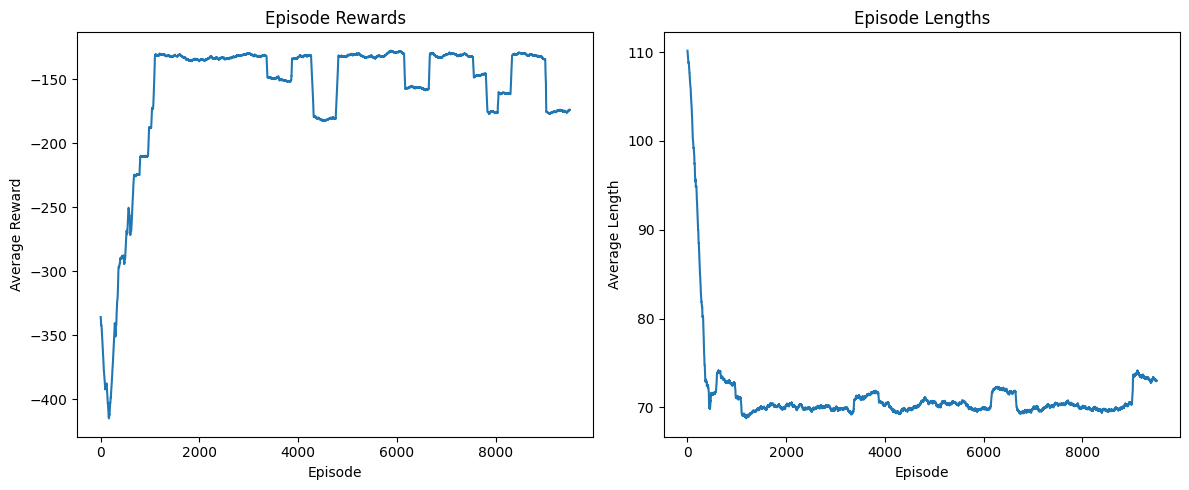

In [ ]:
# Plot rewards and lengths
rolling_length = 500  # Adjust the rolling average window for smoothing
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

# Episode rewards
axs[0].set_title("Episode Rewards")
reward_moving_average = (
    np.convolve(np.array(rewards), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Average Reward")

# Episode lengths
axs[1].set_title("Episode Lengths")
length_moving_average = (
    np.convolve(np.array(episode_lengths), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Average Length")

plt.tight_layout()
plt.show()

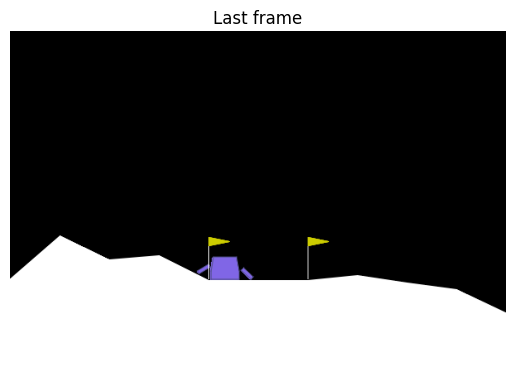

In [ ]:
#Plot last frame
plt.imshow(env.render())
plt.title("Last frame")
plt.axis("off")
plt.show()

Test the Agent

In [ ]:
# Load the trained model
agent.qnetwork.load_state_dict(torch.load("dqn_lunar_lander.pth"))
agent.qnetwork.eval()

# Run one episode to visualize
state, _ = env.reset()
done = False
while not done:
    action = agent.act(state)
    state, _, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    env.render()
env.close()


  agent.qnetwork.load_state_dict(torch.load("dqn_lunar_lander.pth"))



In [ ]:
# Load the trained model
agent.qnetwork.load_state_dict(torch.load("dqn_lunar_lander.pth"))
agent.qnetwork.eval()

# Initialize variables for testing
total_rewards = []

print("Testing the trained agent...\n")

for episode in range(1, num_evaluation_episodes + 1):
    state, _ = env.reset()
    done = False
    episode_reward = 0

    while not done:
        # Select the action greedily (without exploration)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            action = torch.argmax(agent.qnetwork(state_tensor)).item()

        # Perform the action in the environment
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Accumulate reward
        episode_reward += reward
        state = next_state

        # Render the environment (optional)
        env.render()

    total_rewards.append(episode_reward)

env.close()

# Calculate average performance
average_reward = np.mean(total_rewards)
print(f"\nAverage Reward over {num_evaluation_episodes} episodes: {average_reward:.2f}")


  agent.qnetwork.load_state_dict(torch.load("dqn_lunar_lander.pth"))



Testing the trained agent...


Average Reward over 1000 episodes: -131.05
